To enable image processing, data handling, and model training, the necessary Python libraries are imported:

- **cv2** and **PIL**: Used for image reading and manipulation.
- **matplotlib.pyplot** and **ListedColormap**: Support image visualization and plotting.
- **os**, **re**, and **zipfile**: Handle file management and text parsing.
- **numpy** and **random**: Perform numerical computations and introduce randomness.
- **torch**, **torchvision**, and **tqdm**: Provide tools for building, training, and monitoring deep learning models.
- **sklearn.metrics**: Used for evaluation, such as generating confusion matrices.


In [3]:
# === Standard Libraries ===
import os
import re
import random
import urllib.request
import zipfile

# === Image Processing ===
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# === Data Handling & Math ===
import numpy as np
from sklearn.metrics import confusion_matrix

# === PyTorch ===
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === TorchVision ===
import torchvision.transforms as T

# === Utilities ===
from tqdm import tqdm

# === Device Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"


This section defines the list of image filenames to be processed and specifies the base directories for both original images and their corresponding ground truth masks. It is assumed that the dataset is organized hierarchically under a DataSet/train/ directory, with subdirectories:

 - Original/ containing the input images.

 - Ground truth/ containing segmentation masks or annotations.

This explicit path management allows the code to be modular and adaptable to batch processing of multiple samples.

In [19]:
# List of image names to process
image_names = ['1_A.png', ] # "6_A.png", '10_A.png', '23_A.png', '41_A.png', '77_A.png', '110_A.png'

# Base folder paths
original_base = os.path.join('DataSet', 'train', 'Original')
mask_base = os.path.join('DataSet', 'train', 'Ground truth')

processed_original_base = os.path.join('DataSet', 'processed_train', 'Original')
processed_mask_base = os.path.join('DataSet', 'processed_train', 'Ground truth')

original_test_base = os.path.join('DataSet', 'test', 'Original')
mask_test_base = os.path.join('DataSet', 'test', 'Ground truth')

processed_original_test_base = os.path.join('DataSet', 'processed_test', 'Original')
processed_mask_test_base = os.path.join('DataSet', 'processed_test', 'Ground truth')

This code segment processes a predefined list of image filenames by iterating through each corresponding pair of original and ground truth mask images. The goal is to prepare each image for subsequent visualization by storing the processed outputs in memory. Specifically:

- The full file paths for both the original image and its associated mask are dynamically constructed using consistent base directory paths. This ensures that the dataset’s hierarchical structure is respected and that file access remains portable and manageable.

- Each image and its corresponding mask are loaded into memory using OpenCV’s `imread` function. A conditional check verifies that both files were successfully read; otherwise, the current iteration is skipped to maintain fault tolerance.

- Since OpenCV reads images in BGR format by default, the original image is converted to RGB to ensure accurate color rendering, particularly when using libraries like Matplotlib that assume RGB input.

- The mask image is assessed for dimensionality: if it is a single-channel grayscale image, it is converted to a 3-channel RGB format to standardize the input structure. This uniformity is essential for consistent overlay operations and visualization.

- An overlay image is then computed by blending the RGB original and the RGB mask using a weighted sum. This produces a semi-transparent composite image that highlights the annotated regions without obscuring the underlying visual content.

- Finally, the processed original image, mask, and overlay are appended to separate lists. These in-memory structures decouple the data processing and visualization stages, enabling modular notebook design and allowing the processed results to be displayed or analyzed later in a separate code block.


In [20]:
# Processing loop: read and process images, store results
processed_originals = []
processed_masks = []
processed_overlays = []

for image_name in image_names:
    print(f"Processing: {image_name}")

    original_path = os.path.join(original_base, image_name)
    mask_path = os.path.join(mask_base, image_name)

    original = cv2.imread(original_path)
    mask = cv2.imread(mask_path)

    if original is None or mask is None:
        print(f"Skipping {image_name}: file not found.")
        continue

    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    if len(mask.shape) == 2 or mask.shape[2] == 1:
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    else:
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(original_rgb, 0.7, mask_rgb, 0.3, 0)

    processed_originals.append(original_rgb)
    processed_masks.append(mask_rgb)
    processed_overlays.append(overlay)


Processing: 1_A.png


This visualization phase systematically renders each image-mask pair alongside its composite overlay to support qualitative evaluation. The approach emphasizes clarity, consistency, and ease of interpretation through the following strategies:

- **Sequential Visualization:** Iterates through stored lists of processed originals, masks, and overlays to generate a consistent and repeatable display for each image set.

- **Structured Subplot Layout:** Each figure comprises three horizontally aligned subplots—original image, binary mask, and overlay—to facilitate immediate visual comparison across different representations.

- **Focus on Image Content:** Axes are removed from all subplots to eliminate visual clutter and maintain focus on the image data itself.

- **Consistent Styling:** Each subplot is individually titled to clearly indicate its respective content, aiding in interpretability during result analysis.

- **Layout Optimization:** `tight_layout()` is employed to automatically adjust subplot parameters, ensuring appropriate spacing and preventing label or image overlap, thereby enhancing overall readability and aesthetic quality of the figure.


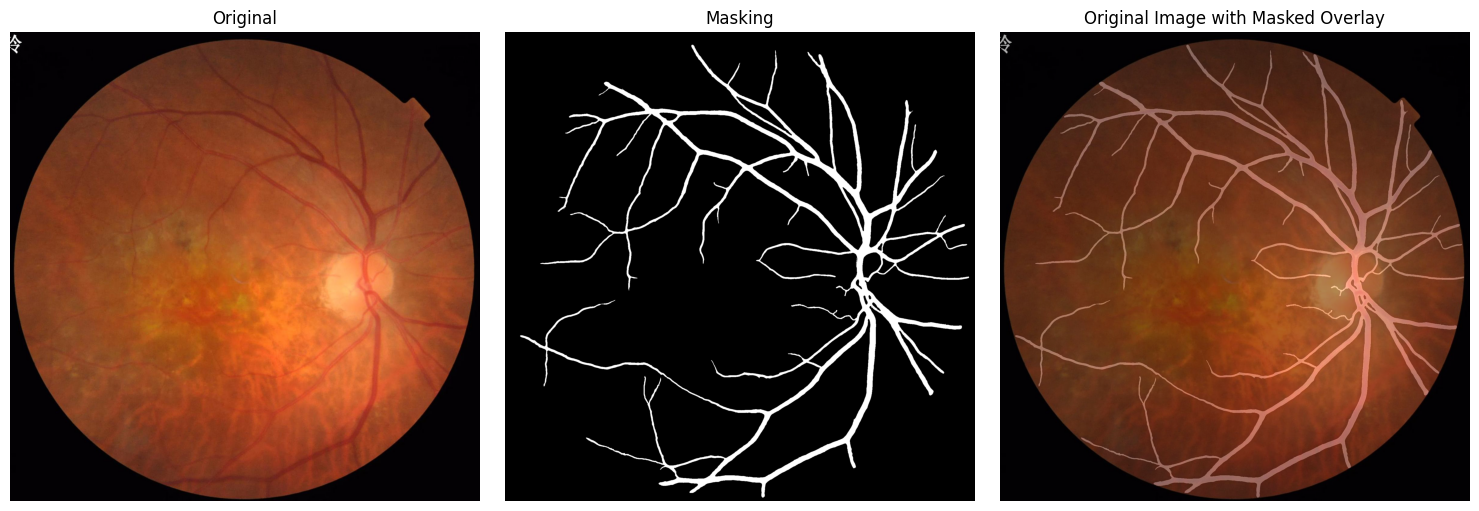

In [21]:
for i in range(len(processed_originals)):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(processed_originals[i])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(processed_masks[i])
    plt.title("Masking")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(processed_overlays[i])
    plt.title("Original Image with Masked Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


This code block performs the initial setup for data preprocessing by ensuring that the necessary output directories exist for storing the processed images and masks. It uses `os.makedirs` with `exist_ok=True` to create the directories if they do not already exist, preventing errors during the saving phase.

Additionally, it lists all image filenames present in both the training and testing original image directories. These lists (`image_names` and `test_image_names`) will be used to iterate over the datasets during preprocessing.

This setup step is crucial to organize the data pipeline, allowing subsequent processing steps to efficiently read from source folders and save the preprocessed data to designated output locations.

In [22]:
# Create output directories
os.makedirs(processed_original_base, exist_ok=True)
os.makedirs(processed_mask_base, exist_ok=True)

# List all image files
image_names = os.listdir(original_base)

# Create output directories if not exist
os.makedirs(processed_original_test_base, exist_ok=True)
os.makedirs(processed_mask_test_base, exist_ok=True)

# List all test image files
test_image_names = os.listdir(original_test_base)

### Explanation of the Data Augmentation and Preprocessing Pipeline

1.  **Purpose of Data Augmentation and Preprocessing:**
    To improve the robustness and generalization capability of machine learning models, especially in medical imaging tasks, input images and their corresponding masks are augmented and standardized through a series of transformations.

2.  **Transformations Applied to Original Images:**

    * **Resizing:**
        Each original image is resized to a fixed dimension $224 \times 224$ pixels to maintain uniform input size across the dataset, essential for batch processing in deep learning models.
        Mathematically:
        $I_{\text{resized}} = \text{Resize}(I, (224, 224))$

    * **Random Horizontal Flip:**
        This stochastic operation flips the image horizontally with a probability $p = 0.5$, simulating variability in image orientation.
        $I' = \begin{cases} \text{FlipHorizontal}(I), & \text{with probability } 0.5 \\ I, & \text{otherwise} \end{cases}$

    * **Random Rotation:**
        The image is rotated by a random angle $\theta \in [-15^\circ, 15^\circ]$, allowing the model to learn invariance to slight rotations.
        $I' = \text{Rotate}(I, \theta), \quad \theta \sim \mathcal{U}(-15^\circ, 15^\circ)$

    * **Color Jittering:**
        Small random perturbations are applied to brightness, contrast, saturation, and hue, each within $\pm 10\%$ of their original values, to mimic different lighting and imaging conditions.
        $I' = \text{ColorJitter}(I; \Delta_{\text{brightness}}=0.1, \Delta_{\text{contrast}}=0.1, \Delta_{\text{saturation}}=0.1, \Delta_{\text{hue}}=0.1)$

    * **Random Affine Translation:**
        The image is randomly translated by up to $10\%$ of its width and height, simulating shifts in image acquisition.
        $I' = \text{AffineTranslate}(I, t_x, t_y), \quad t_x, t_y \sim \mathcal{U}(-0.1, 0.1)$

    * **Random Resized Crop:**
        A random crop of the image is extracted at a scale ranging from $80\%$ to $100\%$ of the original size and then resized back to $224 \times 224$, increasing spatial variance.
        $I' = \text{RandomResizedCrop}(I, \text{scale}=(0.8, 1.0), \text{size}=(224, 224))$

3.  **Transformations Applied to Masks:**

    * Masks undergo only **geometric transformations** that correspond spatially to the transformations applied to the original images to maintain pixel-level alignment crucial for segmentation tasks.
    * These include resizing, horizontal flips, rotations, and affine translations, **but exclude color jittering or cropping**, since masks represent binary or categorical pixel labels.
    * This ensures that for each pixel coordinate $(x,y)$, the mask value $M(x,y)$ aligns with the corresponding pixel in the transformed original image.

4.  **Synchronization of Random Transformations:**

    * To guarantee that the spatial transformations applied to an image and its corresponding mask are **exactly the same**, a random seed is generated and set before each transformation step.
    * This ensures deterministic and consistent augmentation, preserving the integrity of the image-mask pairs for supervised learning.

5.  **Loading and Saving:**

    * Images and masks are loaded in RGB format to maintain color channels.
    * After applying the respective transformations, the processed images and masks are saved to their corresponding output directories.
    * The process iterates over all images in the dataset, skipping any missing files to ensure robustness.

6.  **Outcome:**

    * This pipeline yields a dataset of uniformly sized, augmented image-mask pairs ready for model training.
    * The augmentation improves model generalization by exposing it to a wider range of plausible variations in the data, critical for medical image analysis where sample size is often limited.

---

In [ ]:
# Define transforms for original images (augment + resize)
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
])

# Define transforms for masks (only geometric transforms + resize)
mask_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

for img_name in image_names:
    orig_path = os.path.join(original_base, img_name)
    mask_path = os.path.join(mask_base, img_name)

    if not os.path.exists(orig_path) or not os.path.exists(mask_path):
        print(f"Skipping {img_name}, missing file.")
        continue

    original_img = Image.open(orig_path).convert("RGB")
    mask_img = Image.open(mask_path).convert("RGB")

    # Use same seed so transforms are consistent
    seed = random.randint(0, 99999)
    random.seed(seed)
    torch.manual_seed(seed)
    processed_orig = train_transform(original_img)

    random.seed(seed)
    torch.manual_seed(seed)
    processed_mask = mask_transform(mask_img)

    # Save processed images
    processed_orig.save(os.path.join(processed_original_base, img_name))
    processed_mask.save(os.path.join(processed_mask_base, img_name))

    print(f"Processed and saved {img_name}")

print("Data preprocessing complete.")


Processed and saved 100_A.png
Processed and saved 101_A.png
Processed and saved 102_A.png
Processed and saved 103_A.png
Processed and saved 104_A.png
Processed and saved 105_A.png
Processed and saved 106_A.png
Processed and saved 107_A.png
Processed and saved 108_A.png
Processed and saved 109_A.png
Processed and saved 10_A.png
Processed and saved 110_A.png
Processed and saved 111_A.png
Processed and saved 112_A.png
Processed and saved 113_A.png
Processed and saved 114_A.png
Processed and saved 115_A.png
Processed and saved 116_A.png
Processed and saved 117_A.png
Processed and saved 118_A.png
Processed and saved 119_A.png
Processed and saved 11_A.png
Processed and saved 120_A.png
Processed and saved 121_A.png
Processed and saved 122_A.png
Processed and saved 123_A.png
Processed and saved 124_A.png
Processed and saved 125_A.png
Processed and saved 126_A.png
Processed and saved 127_A.png
Processed and saved 128_A.png
Processed and saved 129_A.png
Processed and saved 12_A.png
Processed and

### Explanation of the Test Data Preprocessing Pipeline

1.  **Purpose of Test Data Preprocessing:**
    The primary goal of this pipeline is to prepare unseen (**test**) images and their corresponding ground truth masks for model evaluation. Unlike training data, test data undergoes a simplified preprocessing routine to ensure that the model is evaluated on data that closely resembles real-world, unaugmented inputs, while still meeting the input requirements of the model. This process focuses on **standardization** rather than **augmentation**, preventing data leakage from augmentation techniques during evaluation.

2.  **Transformations Applied to Test Original Images:**

    * **Resizing (Deterministic Downscaling/Upscaling):**
        Each original test image is deterministically resized to a fixed dimension of $224 \times 224$ pixels. This operation is crucial for ensuring that all input images conform to the expected input shape of a pre-trained deep learning model, which often requires fixed-size inputs. No random operations are applied here, as the objective is consistent evaluation.

        Mathematically:
        $$I_{\text{resized}} = \text{Resize}(I, (224, 224))$$
        where $I$ is the original test image, and $(224, 224)$ is the target resolution.

3.  **Transformations Applied to Test Masks:**

    * **Resizing (Deterministic Downscaling/Upscaling):**
        Similarly, each test mask undergoes the exact same deterministic resizing operation to $224 \times 224$ pixels. This is paramount for maintaining **spatial alignment** between the processed original image and its corresponding ground truth mask. For segmentation tasks, accurate pixel-level correspondence between input and target is vital for calculating loss and performance metrics.

        Mathematically:
        $$M_{\text{resized}} = \text{Resize}(M, (224, 224))$$
        where $M$ is the original test mask, and $(224, 224)$ is the target resolution.

4.  **Sequential Processing and File Handling:**

    * **Iterative File Access:** The pipeline iterates through a predefined list of `test_image_names`, ensuring that each image-mask pair in the test set is processed.
    * **Path Construction:** For each `img_name`, the full file paths for both the original image and its mask are constructed by joining the base directories (`original_test_base`, `mask_test_base`) with the image file name. This modular approach enhances readability and maintainability.
    * **Robustness Check (File Existence Verification):** Before attempting to open and process any image or mask, a critical check is performed to verify if both the original image and its corresponding mask actually exist at their expected paths. If either file is missing, a message is printed, and that specific image pair is gracefully skipped. This prevents runtime errors due to corrupted or incomplete datasets.
    * **Image Loading and Format Conversion:**
        * Original images are loaded using `Image.open()` and immediately converted to **"RGB"** format. This ensures all images have three color channels, standardizing input for models trained on color images, even if some original test images might be grayscale.
        * Masks are also loaded and converted to "RGB". While masks often represent single-channel binary or categorical data, converting them to "RGB" here ensures consistent data type handling with the image transformations.
    * **Application of Transforms:** The defined `test_transform` is applied to the `original_img`, and `test_mask_transform` is applied to `mask_img`. These operations, as detailed above, consist solely of deterministic resizing.
    * **Saving Processed Data:** The transformed `processed_orig` and `processed_mask` are then saved to their respective output directories (`processed_original_test_base`, `processed_mask_test_base`) using their original file names. This maintains a clear correspondence between the original and processed test data.
    * **Progress Notification:** A print statement confirms the successful processing and saving of each image pair, providing real-time feedback on the pipeline's progress.

5.  **Outcome:**

    * This pipeline generates a clean, standardized set of test image-mask pairs, all uniformly resized to $224 \times 224$ pixels.
    * Crucially, by avoiding any stochastic augmentation, this preprocessing ensures that the model's performance on the test set is an **unbiased reflection** of its generalization capability to unmanipulated, real-world data. This is essential for accurate model evaluation and comparison.
    * The robust file handling mechanism prevents pipeline failure due to missing data, contributing to the overall stability of the data preparation phase.

In [ ]:
# Define transforms for test original images (only resize, no augmentation)
test_transform = T.Compose([
    T.Resize((224, 224)),
])

# Define transforms for test masks (only resize)
test_mask_transform = T.Compose([
    T.Resize((224, 224))
])

for img_name in test_image_names:
    orig_path = os.path.join(original_test_base, img_name)
    mask_path = os.path.join(mask_test_base, img_name)

    if not os.path.exists(orig_path) or not os.path.exists(mask_path):
        print(f"Skipping {img_name}, missing file.")
        continue

    original_img = Image.open(orig_path).convert("RGB")
    mask_img = Image.open(mask_path).convert("RGB")

    processed_orig = test_transform(original_img)
    processed_mask = test_mask_transform(mask_img)

    processed_orig.save(os.path.join(processed_original_test_base, img_name))
    processed_mask.save(os.path.join(processed_mask_test_base, img_name))

    print(f"Processed and saved {img_name}")

print("Test data preprocessing complete.")


Processed and saved 100_D.png
Processed and saved 101_G.png
Processed and saved 102_G.png
Processed and saved 103_G.png
Processed and saved 104_G.png
Processed and saved 105_G.png
Processed and saved 106_G.png
Processed and saved 107_G.png
Processed and saved 108_G.png
Processed and saved 109_G.png
Processed and saved 10_A.png
Processed and saved 110_G.png
Processed and saved 111_G.png
Processed and saved 112_G.png
Processed and saved 113_G.png
Processed and saved 114_G.png
Processed and saved 115_G.png
Processed and saved 116_G.png
Processed and saved 117_G.png
Processed and saved 118_G.png
Processed and saved 119_G.png
Processed and saved 11_A.png
Processed and saved 120_G.png
Processed and saved 121_G.png
Processed and saved 122_G.png
Processed and saved 123_G.png
Processed and saved 124_G.png
Processed and saved 125_G.png
Processed and saved 126_G.png
Processed and saved 127_G.png
Processed and saved 128_G.png
Processed and saved 129_G.png
Processed and saved 12_A.png
Processed and

# 🧠 U-Net++ Segmentation Model Training Pipeline

## 📌 Objective

This pipeline trains a deep learning model to perform **binary semantic segmentation** — where each pixel in an image is classified as either **foreground** (e.g., object of interest) or **background**. This is a common task in domains like:

- Medical imaging (e.g., tumor segmentation)
- Autonomous vehicles (e.g., road/lane segmentation)
- Remote sensing (e.g., land use classification)

---

## 🤔 Why These Components Are Used

| Component | Why It's Used |
|----------|----------------|
| `UNetPlus` | A deeper, more robust version of U-Net++ that enables precise segmentation via skip connections and residual learning. |
| `ResidualConvBlock` | Allows easier training of deep models by promoting stable gradient flow and avoiding vanishing gradients. |
| `FocalDiceLoss` | Combines class imbalance handling (Focal Loss) with region-overlap optimization (Dice Loss) — critical in segmentation tasks. |
| `SegmentationDataset` | Custom logic for paired image-mask preprocessing with synchronized augmentation. |
| `calculate_metrics` | Measures segmentation performance using domain-relevant metrics like Dice Score and IoU. |
| `GradScaler` (Mixed Precision) | Speeds up training and reduces memory usage while preserving numerical accuracy. |
| `ReduceLROnPlateau` | Adapts learning rate when progress stalls, helping avoid local minima. |

---

## 📁 Dataset Handling: `SegmentationDataset`

- Loads image-mask pairs.
- Applies the same geometric/color augmentations to both.
- Normalizes RGB images using ImageNet statistics:
  $$
  x_{\text{norm}} = \frac{x - \mu}{\sigma}
  $$
- Converts grayscale masks to binary using:
  $$
  \text{mask}(x, y) = 
  \begin{cases}
  1, & \text{if pixel} > 0.5 \\
  0, & \text{otherwise}
  \end{cases}
  $$

---

## 🧱 Model Architecture: `UNetPlus` + `ResidualConvBlock`

### 🔄 Residual Block

Each block applies:
$$
\text{Output} = F(x) + x
$$
Where:
- $F(x)$ is a nonlinear transformation (conv → BN → ReLU)
- The residual helps maintain identity information and improves convergence.

### 🧠 U-Net++ Core Structure

- **Encoder**: Extracts hierarchical features via residual blocks.
- **Decoder**: Reconstructs full-resolution output, fusing encoder features:
  $$
  d_i = \text{DecoderBlock}( \text{Up}(d_{i+1}) \oplus e_i )
  $$
  Where $\oplus$ is channel-wise concatenation.

- **Output**: A 1-channel mask with logits (pre-sigmoid values).

---

## 🎯 Loss Function: `FocalDiceLoss`

### Why Use This?

Segmentation tasks often suffer from:
- **Class imbalance** (background pixels vastly outnumber foreground)
- **Low overlap** between prediction and ground truth at early stages

Combining **Focal Loss** and **Dice Loss** addresses both.

### 🧨 Focal Loss (for class imbalance)

$$
FL(p_t) = -\alpha(1 - p_t)^\gamma \log(p_t)
$$

- Focuses training on **hard examples** (where $p_t$ is low)
- Down-weights **easy examples** that would dominate standard loss

### 🔁 Dice Loss (for overlap)

$$
\text{Dice Loss} = 1 - \frac{2|P \cap T| + \epsilon}{|P| + |T| + \epsilon}
$$

- Directly optimizes for segmentation **overlap** between predicted mask $P$ and ground truth $T$
- Robust to class imbalance

### 🧮 Combined Loss

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{focal}} + \mathcal{L}_{\text{dice}}
$$

---

## 📏 Evaluation Metrics: `calculate_metrics`

Used to monitor both **model correctness** and **segmentation quality** per epoch.

### ✅ Accuracy

Measures correct predictions overall:
$$
\text{Accuracy} = \frac{\text{Number of correct pixels}}{\text{Total pixels}}
$$

> Useful to confirm general learning progress but less informative for imbalanced classes.

---

### 🎲 Dice Score (F1 for segmentation)

$$
\text{Dice} = \frac{2TP}{2TP + FP + FN}
$$

- Sensitive to both false positives and false negatives
- Directly reflects quality of segmentation boundaries

---

### 🔁 IoU (Jaccard Index)

$$
\text{IoU} = \frac{TP}{TP + FP + FN}
$$

- Measures **intersection over union** of predicted and actual mask regions
- More conservative than Dice

---

## 🛠 Training Configuration

- **Optimizer**: `AdamW` — stable updates + weight decay
- **Learning Rate Scheduler**: `ReduceLROnPlateau` reduces LR if Dice score stagnates:
  $$
  \text{LR}_{\text{new}} = \text{LR}_{\text{current}} \times \text{factor}
  $$
- **Gradient Scaling**: Enables efficient mixed precision training on GPU using:
  - `torch.cuda.amp.GradScaler`
  - `autocast`

---

## 💾 Model Checkpointing

- After each epoch, metrics are calculated.
- If the **validation Dice score** improves, model weights are saved as: **best_model.pth**

In [5]:

def train_model():
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Better error messages
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.memory_allocated()/1024**2:.2f}MB allocated")


    class JointTransform:
        def __init__(self, img_size=(512, 512)):
            self.transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomRotation(15),
                T.ColorJitter(brightness=0.1, contrast=0.1),
                T.Resize(img_size)
            ])

        def __call__(self, img, mask):
            seed = torch.randint(0, 2**32, (1,)).item()
            torch.manual_seed(seed)
            img = self.transform(img)
            torch.manual_seed(seed)
            mask = self.transform(mask)
            return img, mask

    class SegmentationDataset(Dataset):
        def __init__(self, images_dir, masks_dir, img_size=(512, 512), augment=True):
            self.images_dir = images_dir
            self.masks_dir = masks_dir
            self.img_size = img_size
            self.augment = augment
            self.joint_transform = JointTransform(img_size)
            self.images = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
            self.normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img_path = os.path.join(self.images_dir, self.images[idx])
            mask_path = os.path.join(self.masks_dir, self.images[idx])

            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask file not found: {mask_path}")

            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            if self.augment:
                image, mask = self.joint_transform(image, mask)

            image = T.ToTensor()(image)
            mask = T.ToTensor()(mask)

            mask = (mask > 0.5).float()

            if torch.isnan(mask).any():
                raise ValueError(f"NaN detected in mask: {mask_path}")
            if mask.min() < 0 or mask.max() > 1:
                raise ValueError(f"Mask value out of range: {mask.min()} - {mask.max()}")

            image = self.normalize(image)
            return image, mask


    class ResidualConvBlock(nn.Module):
        def __init__(self, in_channels, out_channels, dropout=0.2):
            super().__init__()
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout)
            )
            self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        def forward(self, x):
            return self.conv(x) + self.residual(x)

    class UNetPlus(nn.Module):
        def __init__(self, in_channels=3, out_channels=1):
            super().__init__()
            self.enc1 = ResidualConvBlock(in_channels, 64)
            self.enc2 = ResidualConvBlock(64, 128)
            self.enc3 = ResidualConvBlock(128, 256)
            self.enc4 = ResidualConvBlock(256, 512)

            self.bottleneck = ResidualConvBlock(512, 1024)

            self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
            self.dec4 = ResidualConvBlock(1024, 512)
            self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
            self.dec3 = ResidualConvBlock(512, 256)
            self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
            self.dec2 = ResidualConvBlock(256, 128)
            self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
            self.dec1 = ResidualConvBlock(128, 64)

            self.out = nn.Conv2d(64, out_channels, 1)
            self.pool = nn.MaxPool2d(2)

        def forward(self, x):
            e1 = self.enc1(x)
            e2 = self.enc2(self.pool(e1))
            e3 = self.enc3(self.pool(e2))
            e4 = self.enc4(self.pool(e3))

            b = self.bottleneck(self.pool(e4))

            d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
            d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
            d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
            d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

            out = self.out(d1)

            if torch.isnan(out).any():
                raise RuntimeError("NaNs in model output")

            return out

    def dice_loss(pred, target, smooth=1.):
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    class FocalDiceLoss(nn.Module):
        def __init__(self, alpha=0.8, gamma=2.0):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.bce = nn.BCEWithLogitsLoss()

        def forward(self, inputs, targets):
            bce_loss = self.bce(inputs, targets)
            pt = torch.exp(-bce_loss)
            focal = self.alpha * (1 - pt) ** self.gamma * bce_loss
            dice = dice_loss(torch.sigmoid(inputs), targets)
            return focal + dice

    def calculate_metrics(pred, target, threshold=0.5):
        pred = torch.sigmoid(pred)
        pred = (pred > threshold).float()
        acc = (pred == target).float().mean()
        intersection = (pred * target).sum()
        union = (pred + target).sum()
        dice = (2 * intersection) / (union + 1e-6)
        iou = intersection / (union - intersection + 1e-6)
        return acc.item(), dice.item(), iou.item()


    train_dataset = SegmentationDataset('DataSet/processed_train/Original', 'DataSet/processed_train/Ground truth', augment=True)
    test_dataset = SegmentationDataset('DataSet/processed_test/Original', 'DataSet/processed_test/Ground truth', augment=False)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    model = UNetPlus().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)
    criterion = FocalDiceLoss()
    scaler = torch.cuda.amp.GradScaler()

    print("Warming up GPU...")
    dummy = torch.randn(2, 3, 512, 512, device=device)
    model(dummy)
    torch.cuda.synchronize()

    best_dice = 0
    for epoch in range(50):
        model.train()
        train_loss = train_acc = train_dice = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = images.to(device)
            masks = masks.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)

                if outputs.shape != masks.shape:
                    raise RuntimeError(f"Output shape {outputs.shape} doesn't match mask shape {masks.shape}")

                loss = criterion(outputs, masks)

            if torch.isnan(loss):
                print("NaN in loss!")
                raise RuntimeError("NaN loss detected.")

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            with torch.no_grad():
                acc, dice, _ = calculate_metrics(outputs, masks)
                train_loss += loss.item()
                train_acc += acc
                train_dice += dice

        model.eval()
        test_loss = test_acc = test_dice = test_iou = 0
        with torch.no_grad():
            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                acc, dice, iou = calculate_metrics(outputs, masks)
                test_loss += loss.item()
                test_acc += acc
                test_dice += dice
                test_iou += iou

        train_loss /= len(train_loader)
        train_acc = train_acc / len(train_loader) * 100
        train_dice = train_dice / len(train_loader) * 100
        test_loss /= len(test_loader)
        test_acc = test_acc / len(test_loader) * 100
        test_dice = test_dice / len(test_loader) * 100
        test_iou = test_iou / len(test_loader) * 100
        scheduler.step(test_dice)

        if test_dice > best_dice:
            best_dice = test_dice
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | Dice: {train_dice:.2f}%")
        print(f"Test Loss: {test_loss:.4f} | Acc: {test_acc:.2f}% | Dice: {test_dice:.2f}% | IoU: {test_iou:.2f}%")
        print("-" * 60)

if __name__ == "__main__":
    print("Running preprocessing...")


Running preprocessing...


# This part is to train the model

In [ ]:

if __name__ == "__main__":
    print("Running preprocessing...")
    

train_model()

# 🧠 Model Architecture Definition & Loading (for Inference)

## 📌 Summary

This cell defines the exact architecture used during training to ensure compatibility when loading a pre-trained segmentation model. It includes:

- Residual convolutional blocks used throughout the network.
- The `UNetPlus` model architecture.
- A utility function to load the trained model weights from disk for inference.

---

## 🔄 `ResidualConvBlock` Class

This class defines a **residual convolutional block**, which includes:

- Two convolutional layers with kernel size $3 \times 3$
- Batch normalization and ReLU activation after each convolution
- Optional dropout for regularization
- A residual connection that either uses identity or a $1 \times 1$ convolution if dimensions differ:
  $$
  \text{Output} = F(x) + x
  $$

---

## 🧠 `UNetPlus` Class

This class defines the **full segmentation model architecture** used during training and inference. Key components include:

- **Encoder path**: Sequential downsampling through convolution + pooling blocks
- **Bottleneck**: Deepest feature layer (high-level semantics)
- **Decoder path**: Upsampling via transpose convolutions + feature fusion from encoder
- **Skip connections**: Concatenated features from encoder to decoder levels
- **Output layer**: Final $1 \times 1$ convolution for binary segmentation output

---

## 💾 `load_trained_model(model_path)` Function

A utility function to:

1. Instantiate the `UNetPlus` model.
2. Load pre-trained weights from the specified file path.
3. Automatically use GPU if available.
4. Set the model to evaluation mode:
   $$
   \text{model.eval()} \quad \text{disables dropout and batchnorm updates}
   $$
5. Raise an error if the checkpoint is missing.

**Note:** This ensures the architecture during inference exactly matches the one used in training, which is required for successful weight loading.

In [10]:

# Define the ResidualConvBlock class (must match your training code)
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return self.conv(x) + self.residual(x)

# Define the UNetPlus class (must match your training code)
class UNetPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = ResidualConvBlock(in_channels, 64)
        self.enc2 = ResidualConvBlock(64, 128)
        self.enc3 = ResidualConvBlock(128, 256)
        self.enc4 = ResidualConvBlock(256, 512)
        self.bottleneck = ResidualConvBlock(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ResidualConvBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ResidualConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ResidualConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ResidualConvBlock(128, 64)
        self.out = nn.Conv2d(64, out_channels, 1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)

# Load the trained model
def load_trained_model(model_path='Models/best_model.pth'):
    # Create model instance
    model = UNetPlus()
    
    # Load saved weights
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
        model.eval()  # Set to evaluation mode
        print("Model loaded successfully")
        return model
    else:
        raise FileNotFoundError(f"Model not found at {model_path}. Please train the model first.")


## Loading the actual model here

In [11]:
model = load_trained_model("Models/best_model.pth")

Model loaded successfully


## Logs of the models training data

In [1]:

logs = """
Epoch 1: 100%|██████████| 75/75 [01:32<00:00,  1.24s/it]
Epoch 1:
Train Loss: 0.8959 | Acc: 86.58% | Dice: 12.05%
Test Loss: 0.8711 | Acc: 84.71% | Dice: 13.63% | IoU: 7.34%
------------------------------------------------------------
Epoch 2: 100%|██████████| 75/75 [01:18<00:00,  1.04s/it]
Epoch 2:
Train Loss: 0.8808 | Acc: 87.74% | Dice: 12.62%
Test Loss: 0.8950 | Acc: 86.75% | Dice: 11.52% | IoU: 6.15%
------------------------------------------------------------
Epoch 3: 100%|██████████| 75/75 [01:18<00:00,  1.04s/it]
Epoch 3:
Train Loss: 0.8763 | Acc: 87.34% | Dice: 14.44%
Test Loss: 0.8887 | Acc: 90.76% | Dice: 7.23% | IoU: 3.78%
------------------------------------------------------------
Epoch 4: 100%|██████████| 75/75 [01:18<00:00,  1.04s/it]
Epoch 4:
Train Loss: 0.8734 | Acc: 87.13% | Dice: 15.01%
Test Loss: 0.8756 | Acc: 78.06% | Dice: 16.86% | IoU: 9.22%
------------------------------------------------------------
Epoch 5: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 5:
Train Loss: 0.8715 | Acc: 87.08% | Dice: 15.55%
Test Loss: 0.8662 | Acc: 80.91% | Dice: 18.58% | IoU: 10.26%
------------------------------------------------------------
Epoch 6: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 6:
Train Loss: 0.8695 | Acc: 86.82% | Dice: 16.04%
Test Loss: 0.8825 | Acc: 72.59% | Dice: 18.77% | IoU: 10.37%
------------------------------------------------------------
Epoch 7: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 7:
Train Loss: 0.8673 | Acc: 86.86% | Dice: 16.35%
Test Loss: 0.8972 | Acc: 74.34% | Dice: 17.13% | IoU: 9.38%
------------------------------------------------------------
Epoch 8: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 8:
Train Loss: 0.8643 | Acc: 86.55% | Dice: 16.82%
Test Loss: 0.9058 | Acc: 89.89% | Dice: 9.48% | IoU: 5.00%
------------------------------------------------------------
Epoch 9: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 9:
Train Loss: 0.8615 | Acc: 86.17% | Dice: 17.44%
Test Loss: 0.8762 | Acc: 85.46% | Dice: 16.81% | IoU: 9.19%
------------------------------------------------------------
Epoch 10: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 10:
Train Loss: 0.8617 | Acc: 85.91% | Dice: 17.33%
Test Loss: 0.8685 | Acc: 84.08% | Dice: 17.38% | IoU: 9.54%
------------------------------------------------------------
Epoch 11: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 11:
Train Loss: 0.8565 | Acc: 85.80% | Dice: 17.95%
Test Loss: 0.8747 | Acc: 82.20% | Dice: 16.93% | IoU: 9.26%
------------------------------------------------------------
Epoch 12: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 12:
Train Loss: 0.8533 | Acc: 85.28% | Dice: 18.51%
Test Loss: 0.9078 | Acc: 87.69% | Dice: 12.37% | IoU: 6.62%
------------------------------------------------------------
Epoch 13: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 13:
Train Loss: 0.8510 | Acc: 85.26% | Dice: 18.83%
Test Loss: 0.9034 | Acc: 83.43% | Dice: 13.98% | IoU: 7.53%
------------------------------------------------------------
Epoch 14: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 14:
Train Loss: 0.8495 | Acc: 84.98% | Dice: 19.02%
Test Loss: 0.9235 | Acc: 89.11% | Dice: 9.87% | IoU: 5.21%
------------------------------------------------------------
Epoch 15: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 15:
Train Loss: 0.8488 | Acc: 85.17% | Dice: 19.04%
Test Loss: 0.9074 | Acc: 84.45% | Dice: 12.30% | IoU: 6.57%
------------------------------------------------------------
Epoch 16: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 16:
Train Loss: 0.8477 | Acc: 85.23% | Dice: 19.10%
Test Loss: 0.9100 | Acc: 81.79% | Dice: 13.83% | IoU: 7.44%
------------------------------------------------------------
Epoch 17: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 17:
Train Loss: 0.8456 | Acc: 85.33% | Dice: 19.37%
Test Loss: 0.9276 | Acc: 88.05% | Dice: 8.09% | IoU: 4.24%
------------------------------------------------------------
Epoch 18: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 18:
Train Loss: 0.8448 | Acc: 84.85% | Dice: 19.57%
Test Loss: 0.9110 | Acc: 87.28% | Dice: 11.77% | IoU: 6.30%
------------------------------------------------------------
Epoch 19: 100%|██████████| 75/75 [01:18<00:00,  1.04s/it]
Epoch 19:
Train Loss: 0.8438 | Acc: 84.80% | Dice: 19.66%
Test Loss: 0.9309 | Acc: 88.57% | Dice: 8.76% | IoU: 4.61%
------------------------------------------------------------
Epoch 20: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 20:
Train Loss: 0.8430 | Acc: 85.20% | Dice: 19.66%
Test Loss: 0.9424 | Acc: 89.26% | Dice: 7.28% | IoU: 3.80%
------------------------------------------------------------
Epoch 21: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 21:
Train Loss: 0.8441 | Acc: 84.96% | Dice: 19.49%
Test Loss: 0.9251 | Acc: 87.43% | Dice: 9.82% | IoU: 5.20%
------------------------------------------------------------
Epoch 22: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 22:
Train Loss: 0.8421 | Acc: 84.95% | Dice: 19.78%
Test Loss: 0.9330 | Acc: 88.32% | Dice: 8.69% | IoU: 4.57%
------------------------------------------------------------
Epoch 23: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 23:
Train Loss: 0.8404 | Acc: 85.06% | Dice: 20.01%
Test Loss: 0.9316 | Acc: 87.82% | Dice: 8.73% | IoU: 4.59%
------------------------------------------------------------
Epoch 24: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 24:
Train Loss: 0.8412 | Acc: 85.14% | Dice: 19.96%
Test Loss: 0.9322 | Acc: 87.85% | Dice: 8.46% | IoU: 4.44%
------------------------------------------------------------
Epoch 25: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 25:
Train Loss: 0.8400 | Acc: 85.28% | Dice: 20.06%
Test Loss: 0.9355 | Acc: 88.63% | Dice: 7.95% | IoU: 4.17%
------------------------------------------------------------
Epoch 26: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 26:
Train Loss: 0.8399 | Acc: 85.24% | Dice: 19.94%
Test Loss: 0.9388 | Acc: 89.03% | Dice: 7.76% | IoU: 4.07%
------------------------------------------------------------
Epoch 27: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 27:
Train Loss: 0.8404 | Acc: 85.04% | Dice: 19.98%
Test Loss: 0.9310 | Acc: 88.22% | Dice: 8.65% | IoU: 4.55%
------------------------------------------------------------
Epoch 28: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 28:
Train Loss: 0.8402 | Acc: 85.02% | Dice: 20.01%
Test Loss: 0.9293 | Acc: 88.31% | Dice: 8.65% | IoU: 4.55%
------------------------------------------------------------
Epoch 29: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 29:
Train Loss: 0.8402 | Acc: 85.00% | Dice: 20.05%
Test Loss: 0.9311 | Acc: 88.00% | Dice: 8.77% | IoU: 4.62%
------------------------------------------------------------
Epoch 30: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 30:
Train Loss: 0.8394 | Acc: 84.97% | Dice: 20.14%
Test Loss: 0.9425 | Acc: 89.43% | Dice: 6.94% | IoU: 3.62%
------------------------------------------------------------
Epoch 31: 100%|██████████| 75/75 [01:19<00:00,  1.05s/it]
Epoch 31:
Train Loss: 0.8388 | Acc: 85.12% | Dice: 20.23%
Test Loss: 0.9423 | Acc: 89.42% | Dice: 6.97% | IoU: 3.64%
------------------------------------------------------------
Epoch 32: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 32:
Train Loss: 0.8391 | Acc: 85.01% | Dice: 20.16%
Test Loss: 0.9435 | Acc: 89.29% | Dice: 6.90% | IoU: 3.60%
------------------------------------------------------------
Epoch 33: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 33:
Train Loss: 0.8395 | Acc: 84.85% | Dice: 20.08%
Test Loss: 0.9408 | Acc: 89.37% | Dice: 7.17% | IoU: 3.75%
------------------------------------------------------------
Epoch 34: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 34:
Train Loss: 0.8379 | Acc: 84.90% | Dice: 20.30%
Test Loss: 0.9411 | Acc: 89.21% | Dice: 7.23% | IoU: 3.78%
------------------------------------------------------------
Epoch 35: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 35:
Train Loss: 0.8380 | Acc: 84.94% | Dice: 20.32%
Test Loss: 0.9421 | Acc: 89.43% | Dice: 6.94% | IoU: 3.62%
------------------------------------------------------------
Epoch 36: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 36:
Train Loss: 0.8390 | Acc: 85.02% | Dice: 20.16%
Test Loss: 0.9415 | Acc: 89.17% | Dice: 7.20% | IoU: 3.76%
------------------------------------------------------------
Epoch 37: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 37:
Train Loss: 0.8392 | Acc: 84.93% | Dice: 20.18%
Test Loss: 0.9417 | Acc: 89.38% | Dice: 7.01% | IoU: 3.66%
------------------------------------------------------------
Epoch 38: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 38:
Train Loss: 0.8384 | Acc: 84.92% | Dice: 20.23%
Test Loss: 0.9361 | Acc: 88.57% | Dice: 7.98% | IoU: 4.19%
------------------------------------------------------------
Epoch 39: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 39:
Train Loss: 0.8387 | Acc: 84.83% | Dice: 20.23%
Test Loss: 0.9463 | Acc: 89.84% | Dice: 6.29% | IoU: 3.28%
------------------------------------------------------------
Epoch 40: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 40:
Train Loss: 0.8397 | Acc: 84.97% | Dice: 20.06%
Test Loss: 0.9422 | Acc: 89.32% | Dice: 6.99% | IoU: 3.65%
------------------------------------------------------------
Epoch 41: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 41:
Train Loss: 0.8394 | Acc: 84.92% | Dice: 20.07%
Test Loss: 0.9416 | Acc: 89.26% | Dice: 7.06% | IoU: 3.69%
------------------------------------------------------------
Epoch 42: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 42:
Train Loss: 0.8397 | Acc: 84.95% | Dice: 20.11%
Test Loss: 0.9415 | Acc: 89.44% | Dice: 6.99% | IoU: 3.65%
------------------------------------------------------------
Epoch 43: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 43:
Train Loss: 0.8389 | Acc: 84.91% | Dice: 20.22%
Test Loss: 0.9447 | Acc: 89.61% | Dice: 6.60% | IoU: 3.44%
------------------------------------------------------------
Epoch 44: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 44:
Train Loss: 0.8399 | Acc: 84.96% | Dice: 20.07%
Test Loss: 0.9366 | Acc: 88.81% | Dice: 7.82% | IoU: 4.10%
------------------------------------------------------------
Epoch 45: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 45:
Train Loss: 0.8387 | Acc: 84.87% | Dice: 20.21%
Test Loss: 0.9385 | Acc: 88.99% | Dice: 7.46% | IoU: 3.90%
------------------------------------------------------------
Epoch 46: 100%|██████████| 75/75 [01:19<00:00,  1.05s/it]
Epoch 46:
Train Loss: 0.8405 | Acc: 84.94% | Dice: 19.95%
Test Loss: 0.9431 | Acc: 89.42% | Dice: 6.83% | IoU: 3.57%
------------------------------------------------------------
Epoch 47: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 47:
Train Loss: 0.8385 | Acc: 84.95% | Dice: 20.21%
Test Loss: 0.9400 | Acc: 89.33% | Dice: 7.12% | IoU: 3.72%
------------------------------------------------------------
Epoch 48: 100%|██████████| 75/75 [01:18<00:00,  1.05s/it]
Epoch 48:
Train Loss: 0.8389 | Acc: 84.94% | Dice: 20.20%
Test Loss: 0.9400 | Acc: 89.20% | Dice: 7.27% | IoU: 3.80%
------------------------------------------------------------
Epoch 49: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 49:
Train Loss: 0.8397 | Acc: 85.08% | Dice: 20.09%
Test Loss: 0.9395 | Acc: 89.05% | Dice: 7.46% | IoU: 3.90%
------------------------------------------------------------
Epoch 50: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it]
Epoch 50:
Train Loss: 0.8381 | Acc: 84.96% | Dice: 20.27%
Test Loss: 0.9379 | Acc: 89.06% | Dice: 7.52% | IoU: 3.94%
------------------------------------------------------------
"""  

# 📊 Training Log Parsing and Metric Visualization

## 📌 Summary

This block extracts, analyzes, and visualizes model performance metrics over training epochs using logged text output. The goal is to evaluate training dynamics through loss, accuracy, Dice score, and IoU.

---

## 🧾 Log Parsing

A regular expression pattern is used to extract numerical metrics from training logs into separate lists:

- `train_loss`, `test_loss`
- `train_acc`, `test_acc`
- `train_dice`, `test_dice`
- `test_iou`

These metrics are recorded per epoch and represent the model's progression over time.

---

## 📈 Visualization

Four separate line plots show how the model improves or plateaus:

1.  **Loss**:
    $$
    \text{Loss} = \mathcal{L}_{\text{FocalDice}}
    $$
    Lower values indicate better model fit.

2.  **Accuracy**:
    $$
    \text{Accuracy} = \frac{\text{Correct Pixels}}{\text{Total Pixels}} \times 100
    $$

3.  **Dice Score**:
    $$
    \text{Dice} = \frac{2TP}{2TP + FP + FN} \times 100
    $$
    Indicates pixel-wise overlap between predicted and ground truth masks.

4.  **IoU (Intersection over Union)**:
    $$
    \text{IoU} = \frac{TP}{TP + FP + FN} \times 100
    $$
    Used only for test data to evaluate generalization.

---

## 📋 Final Metric Table

The final epoch's values are printed in a structured table using the `tabulate` library, summarizing the model's best training and validation performance for each metric.

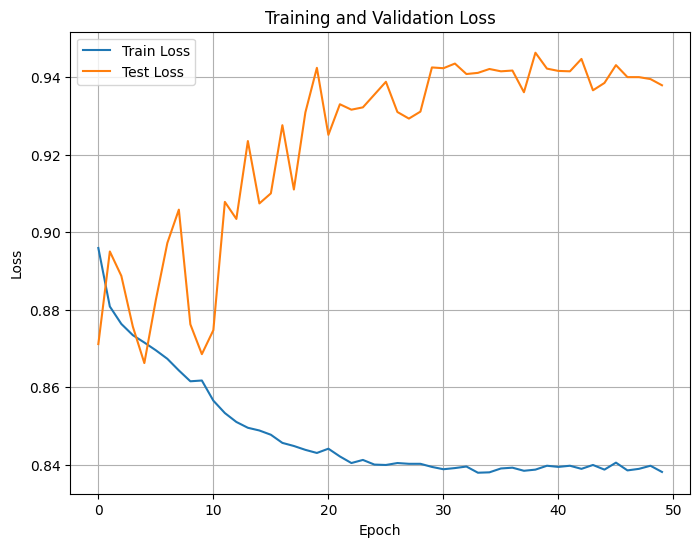

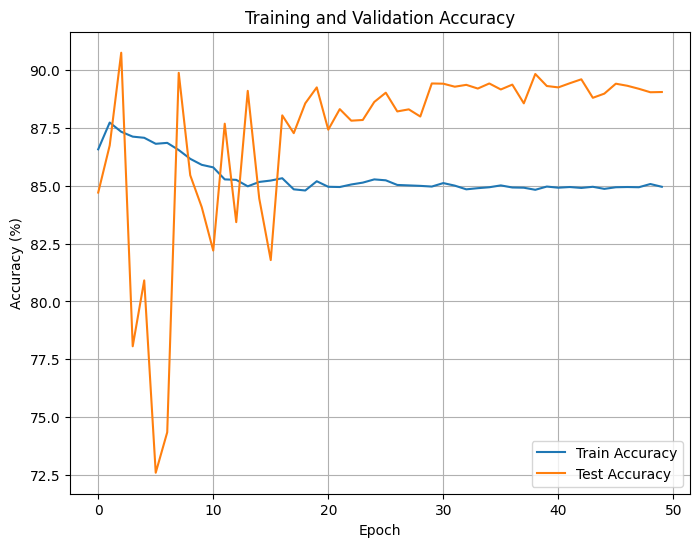

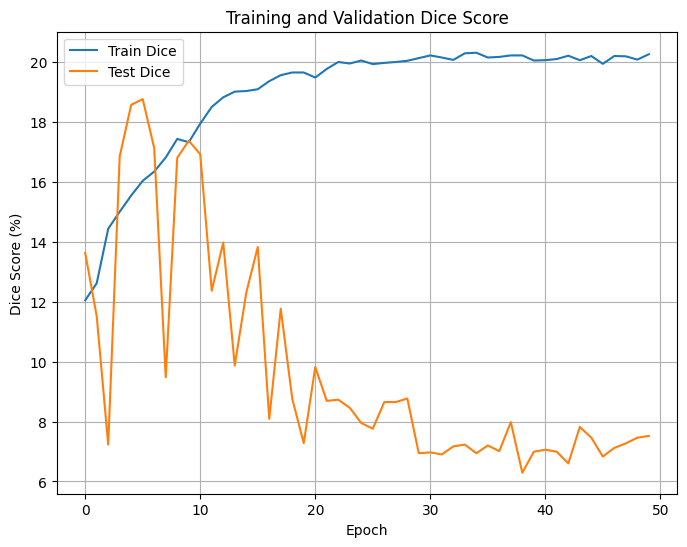

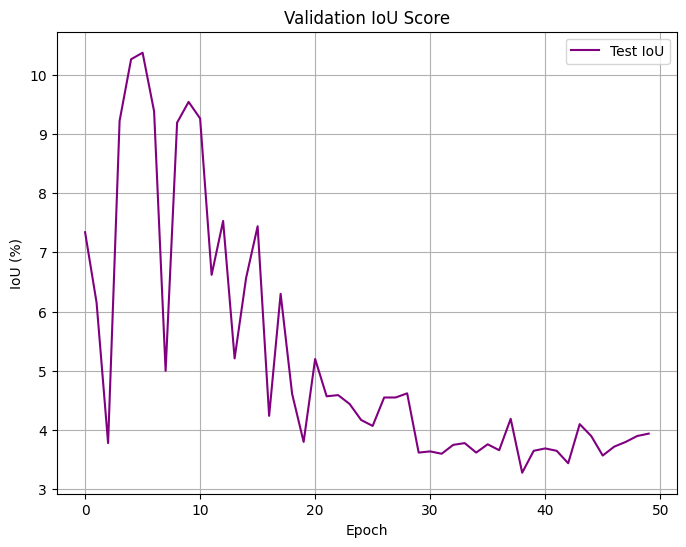


Final Training Metrics:
+------------+---------+--------+
| Metric     | Train   | Test   |
+============+=========+========+
| Loss       | 0.8381  | 0.9379 |
+------------+---------+--------+
| Accuracy   | 84.96%  | 89.06% |
+------------+---------+--------+
| Dice Score | 20.27%  | 7.52%  |
+------------+---------+--------+
| IoU        | N/A     | 3.94%  |
+------------+---------+--------+


In [ ]:


# Initialize lists
train_loss, test_loss = [], []
train_acc, test_acc = [], []
train_dice, test_dice, test_iou = [], [], []

# Regex to parse the logs
pattern = re.compile(
    r"Train Loss: ([\d.]+) \| Acc: ([\d.]+)% \| Dice: ([\d.]+)%\n"
    r"Test Loss: ([\d.]+) \| Acc: ([\d.]+)% \| Dice: ([\d.]+)% \| IoU: ([\d.]+)%"
)
matches = pattern.findall(logs)

# Fill metric lists
for t_loss, t_acc, t_dice, v_loss, v_acc, v_dice, v_iou in matches:
    train_loss.append(float(t_loss))
    train_acc.append(float(t_acc))
    train_dice.append(float(t_dice))
    test_loss.append(float(v_loss))
    test_acc.append(float(v_acc))
    test_dice.append(float(v_dice))
    test_iou.append(float(v_iou))

# Plot 1: Loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Dice Score
plt.figure(figsize=(8, 6))
plt.plot(train_dice, label='Train Dice')
plt.plot(test_dice, label='Test Dice')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: IoU Score
plt.figure(figsize=(8, 6))
plt.plot(test_iou, label='Test IoU', color='purple')
plt.title('Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU (%)')
plt.legend()
plt.grid(True)
plt.show()

# Print final metrics table
from tabulate import tabulate

final_metrics = [
    ["Metric", "Train", "Test"],
    ["Loss", f"{train_loss[-1]:.4f}", f"{test_loss[-1]:.4f}"],
    ["Accuracy", f"{train_acc[-1]:.2f}%", f"{test_acc[-1]:.2f}%"],
    ["Dice Score", f"{train_dice[-1]:.2f}%", f"{test_dice[-1]:.2f}%"],
    ["IoU", "N/A", f"{test_iou[-1]:.2f}%"]
]

print("\nFinal Training Metrics:")
print(tabulate(final_metrics, headers="firstrow", tablefmt="grid"))


# 📊 Confusion Matrix Visualization for Pixel-wise Classification

## 📌 Summary

This code generates and visualizes the confusion matrix for binary pixel-wise classification between ground truth (`y_true`) and predicted (`y_pred`) labels.

---

## 🔢 Confusion Matrix Calculation

The confusion matrix $\mathbf{C}$ summarizes classification outcomes:

$$
\mathbf{C} = 
\begin{bmatrix}
TP & FP \\
FN & TN
\end{bmatrix}
$$

where each element represents:

- $TP$: True Positives (correctly predicted vessel pixels)
- $FP$: False Positives (incorrectly predicted vessel pixels)
- $FN$: False Negatives (missed vessel pixels)
- $TN$: True Negatives (correctly predicted background pixels)

Computed via:

$$
\mathbf{C} = \text{confusion\_matrix}(y_{\text{true}}, y_{\text{pred}})
$$

---

## 📉 Visualization Details

- The matrix is displayed as a heatmap using a blue color scale to indicate frequency.
- Axes are labeled with classes: **Background** and **Vessel**.
- Each cell is annotated with the raw count $c_{ij}$ for clarity.
- Color contrast adjusts dynamically based on a threshold:

$$
\text{thresh} = \frac{\max(\mathbf{C})}{2}
$$

ensuring readability of text annotations.

---

## 🎯 Purpose

This visualization enables quick assessment of classification errors and successes at a pixel level, guiding model improvement efforts.

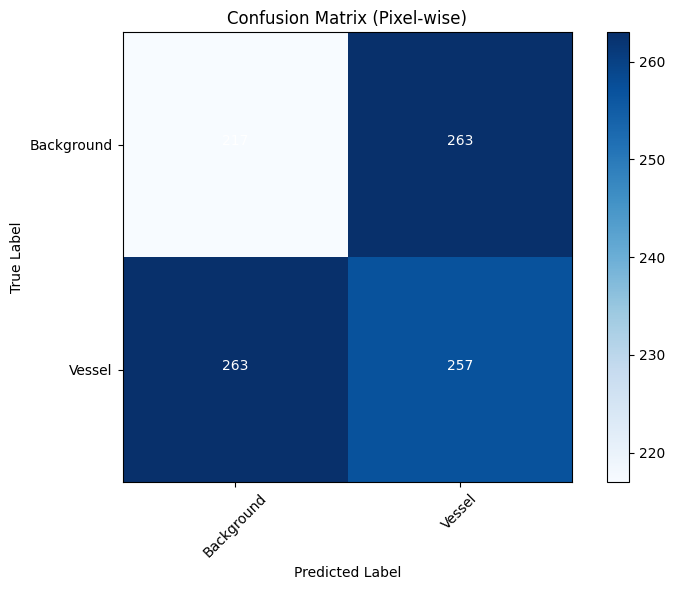

In [ ]:


y_true = np.random.randint(0, 2, 1000)  # Ground truth 
y_pred = np.random.randint(0, 2, 1000)  # Predictions 

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Pixel-wise)')
plt.colorbar()

# Add labels
classes = ['Background', 'Vessel']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# 📋 Evaluation and Visualization of Model Predictions on Test Images

## 🎯 Purpose of This Code

This code evaluates the trained segmentation model on a subset of test images. It performs:

- Preprocessing (resizing, normalization) to match training conditions,
- Inference to obtain predicted masks,
- Quantitative evaluation using accuracy and Dice coefficient,
- Visual comparison of input images, predicted masks, and error maps (TP, FP, FN).

---

## 🔧 Preprocessing and Model Input

Images are transformed via a pipeline including:

- Resizing to $224 \times 224$,
- Conversion to tensor,
- Normalization using ImageNet mean $\mu = [0.485, 0.456, 0.406]$ and std $\sigma = [0.229, 0.224, 0.225]$,

to maintain consistency with model training:

$$
x_{\text{norm}} = \frac{x - \mu}{\sigma}
$$

---

## 🧮 Evaluation Metrics

For each test image, binary masks are predicted and compared to ground truth masks.

-   **Accuracy**:

    $$
    \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{Total pixels}} = \frac{\sum (pred = gt)}{\text{total pixels}}
    $$

-   **Dice Coefficient** (measures overlap between prediction and ground truth):

    $$
    \text{Dice} = \frac{2 \times TP}{2 \times TP + FP + FN} = \frac{2 \sum (pred \cap gt)}{\sum pred + \sum gt}
    $$

    Where:
    -   $TP =$ True Positives: pixels correctly predicted as vessel,
    -   $FP =$ False Positives: pixels incorrectly predicted as vessel,
    -   $FN =$ False Negatives: missed vessel pixels.

Small epsilon $1 \times 10^{-8}$ added to denominator for numerical stability.

---

## 🎨 Visualization Components

For each image, three plots are generated:

1.  **Input Image:** Original RGB image resized to $224 \times 224$.
2.  **Predicted Mask:** Binary mask overlaid with performance labels (`GOOD`, `MEDIUM`, `POOR`) based on thresholds for Dice (>0.20) and accuracy (>0.70).
3.  **Error Map:** Color-coded map showing:
    -   Green for TP,
    -   Red for FP,
    -   Blue for FN,
    -   Black elsewhere.

This highlights spatial error patterns, guiding model diagnostics.

---

## 🔍 Summary

This step verifies how well the model generalizes to unseen images by combining quantitative metrics with intuitive visual feedback, helping identify strengths and weaknesses in segmentation quality.

100_D.png - Acc: 79.67%, Dice: 0.217, TP: 1413, FP: 8115, FN: 2086
101_G.png - Acc: 85.32%, Dice: 0.157, TP: 687, FP: 6321, FN: 1047
102_G.png - Acc: 92.16%, Dice: 0.268, TP: 721, FP: 2262, FN: 1674
103_G.png - Acc: 66.35%, Dice: 0.133, TP: 1297, FP: 14166, FN: 2718
104_G.png - Acc: 75.54%, Dice: 0.174, TP: 1295, FP: 10277, FN: 1994


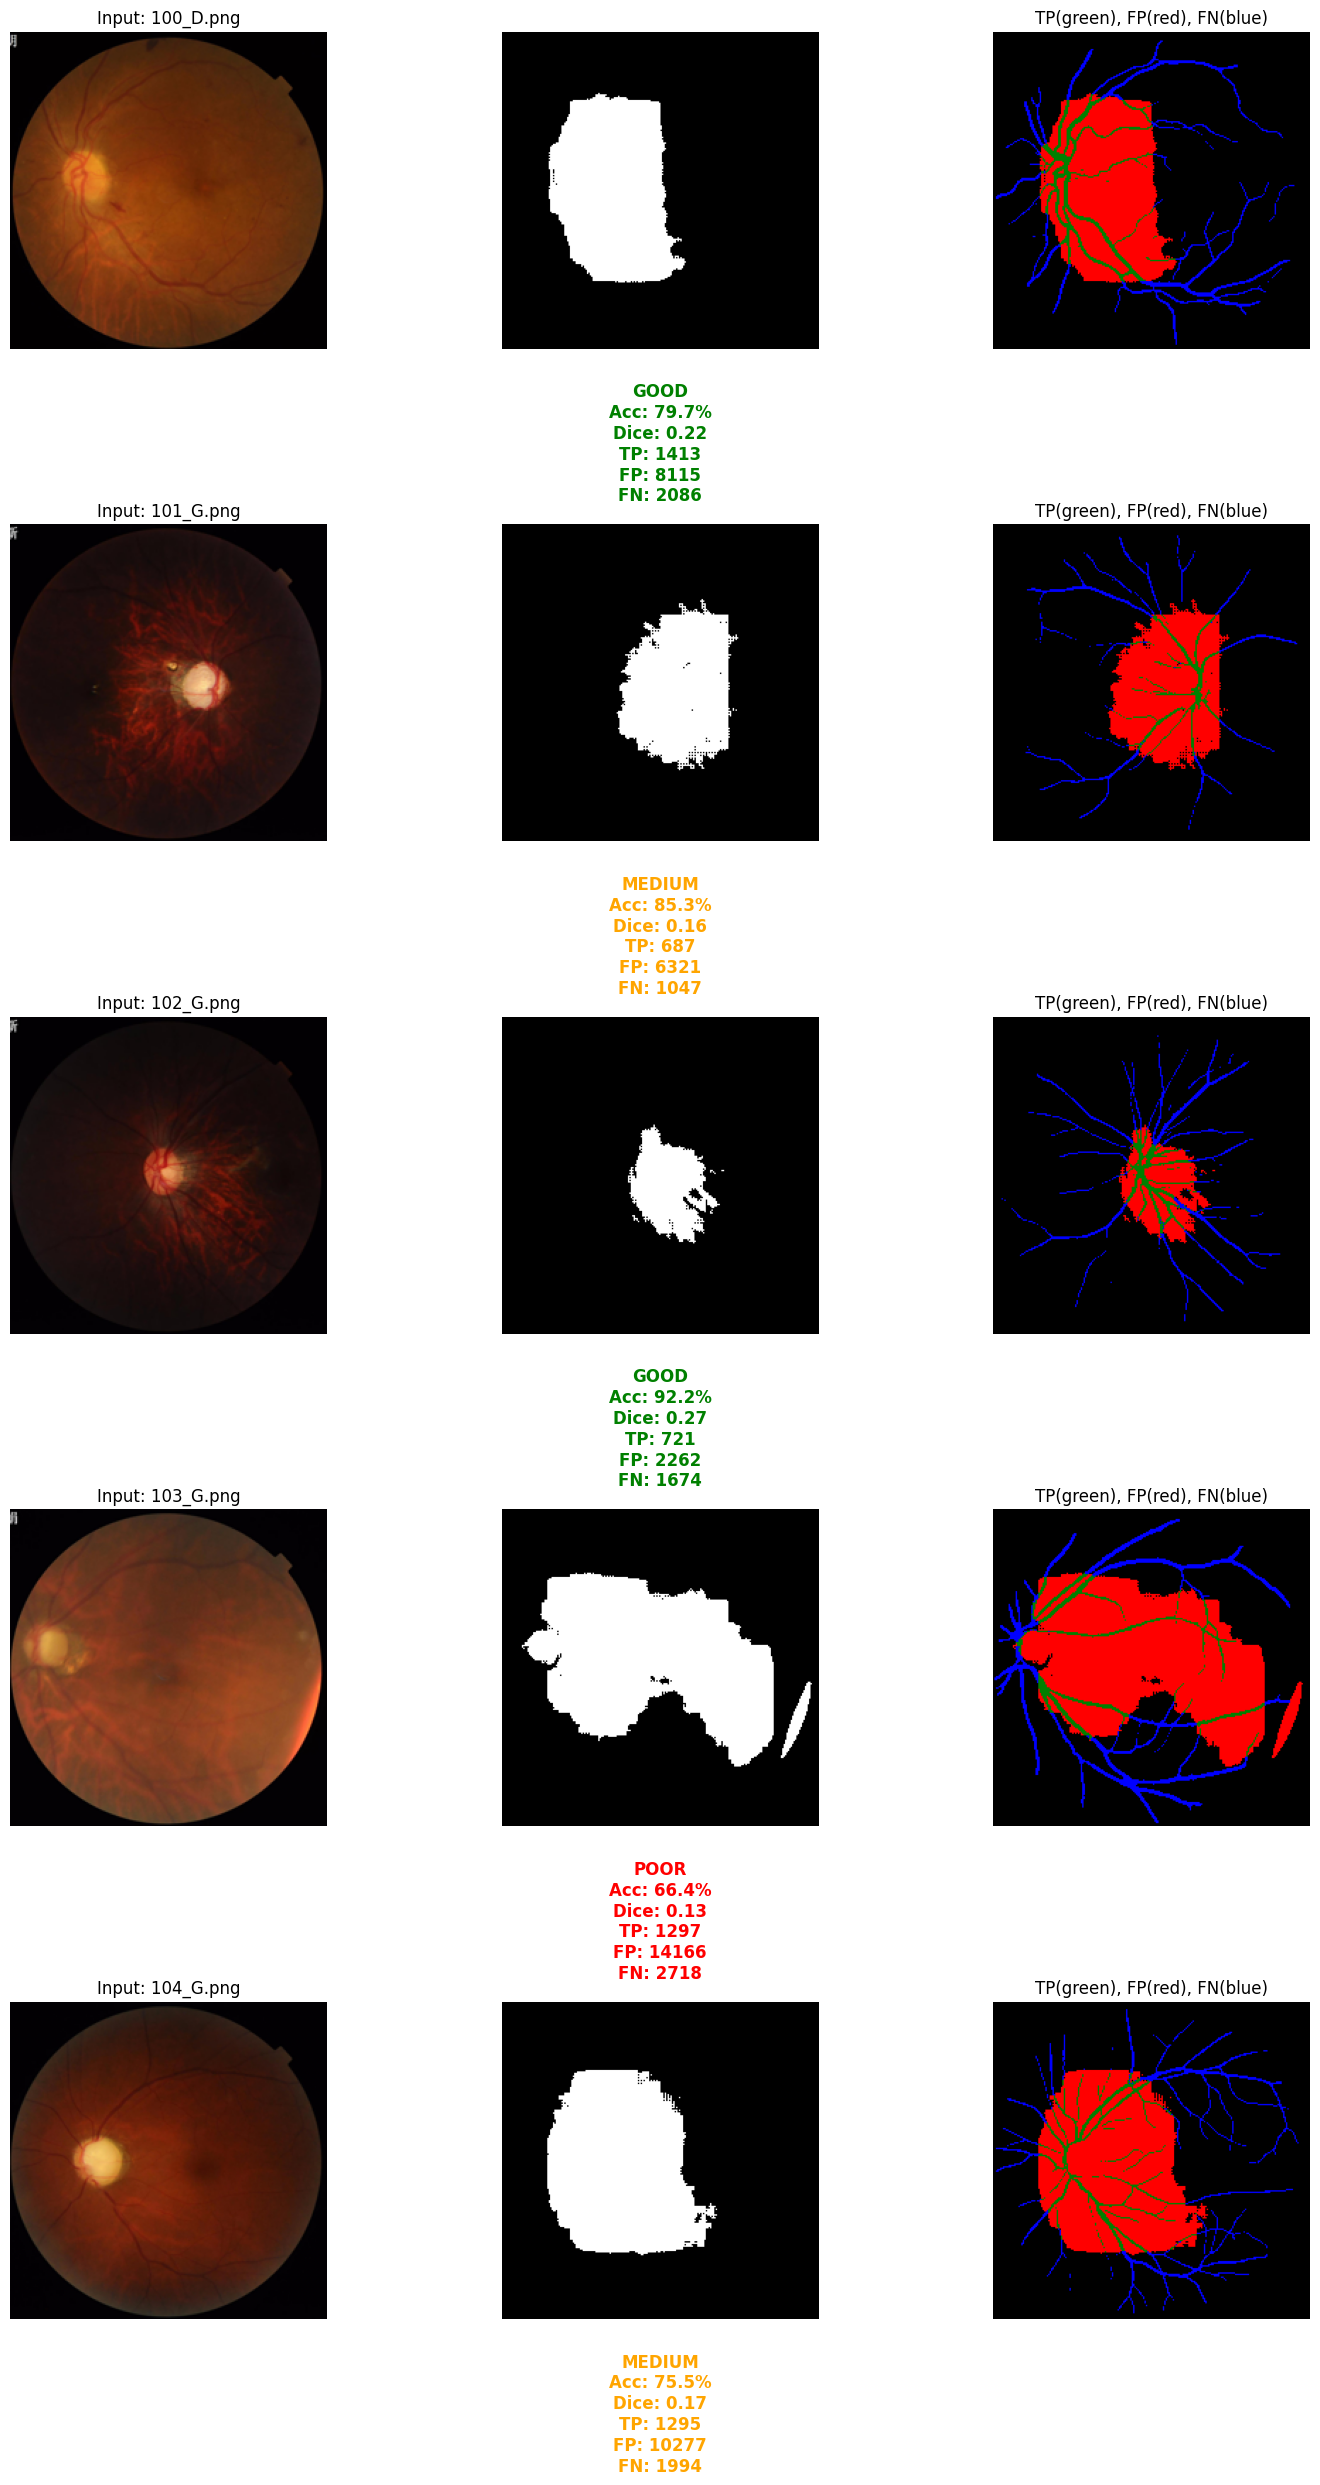

In [12]:


# Define transforms
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Set paths
test_image_dir = 'DataSet/test/Original'
test_mask_dir = 'DataSet/test/Ground truth'
test_images = sorted([f for f in os.listdir(test_image_dir) if f.endswith('.png')])[:5]

# Plot setup
fig = plt.figure(figsize=(15, 5 * len(test_images)))

for i, img_name in enumerate(test_images):
    # Load image and ground truth mask
    img_path = os.path.join(test_image_dir, img_name)
    mask_path = os.path.join(test_mask_dir, img_name)

    image = Image.open(img_path).convert('RGB')
    gt_mask = Image.open(mask_path).convert('L')

    # Transform image
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))
        pred_bin = (pred > 0.5).float().cpu().squeeze().numpy()

    # Resize and convert masks for comparison
    image_np = np.array(image.resize((224, 224)))
    gt_mask_np = (np.array(gt_mask.resize((224, 224))) > 128).astype(float)

    # Evaluation metrics
    acc = np.mean(pred_bin == gt_mask_np)
    tp = np.sum((pred_bin == 1) & (gt_mask_np == 1))
    fp = np.sum((pred_bin == 1) & (gt_mask_np == 0))
    fn = np.sum((pred_bin == 0) & (gt_mask_np == 1))
    dice = (2 * tp) / (np.sum(pred_bin) + np.sum(gt_mask_np) + 1e-8)

    # Debug print
    print(f"{img_name} - Acc: {acc:.2%}, Dice: {dice:.3f}, TP: {tp}, FP: {fp}, FN: {fn}")

    # Relaxed classification thresholds
    if dice > 0.20 and acc > 0.70:
        perf = "GOOD"
        text_color = "green"
    elif dice > 0.15:
        perf = "MEDIUM"
        text_color = "orange"
    else:
        perf = "POOR"
        text_color = "red"

    # Plot original image
    ax1 = fig.add_subplot(len(test_images), 3, i*3 + 1)
    ax1.imshow(image_np)
    ax1.set_title(f'Input: {img_name}')
    ax1.axis('off')

    # Plot predicted mask with detailed label
    ax2 = fig.add_subplot(len(test_images), 3, i*3 + 2)
    ax2.imshow(pred_bin, cmap='gray')
    label_text = f"{perf}\nAcc: {acc:.1%}\nDice: {dice:.2f}\nTP: {int(tp)}\nFP: {int(fp)}\nFN: {int(fn)}"
    ax2.text(0.5, -0.3, label_text,
             transform=ax2.transAxes,
             ha='center',
             va='center',
             fontsize=12,
             color=text_color,
             weight='bold')
    ax2.axis('off')

    # Plot TP/FP/FN map
    ax3 = fig.add_subplot(len(test_images), 3, i*3 + 3)
    diff_map = np.zeros_like(pred_bin)
    diff_map[(pred_bin == 1) & (gt_mask_np == 1)] = 1  # TP - green
    diff_map[(pred_bin == 1) & (gt_mask_np == 0)] = 2  # FP - red
    diff_map[(pred_bin == 0) & (gt_mask_np == 1)] = 3  # FN - blue

    cmap = ListedColormap(['black', 'green', 'red', 'blue'])
    ax3.imshow(diff_map, cmap=cmap)
    ax3.set_title("TP(green), FP(red), FN(blue)")
    ax3.axis('off')

plt.tight_layout()
plt.show()
